In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import learners
import learn_ann
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from keras.regularizers import Regularizer
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [4]:
X, Y = learn_ann.read_dataset('/home/shannon/HMRI/experiments/datasets/functions/add5.npz')

In [5]:
X_trg, Y_trg, X_tst, Y_tst = learn_ann.random_split(X, Y, 64, 123456789)

In [6]:
Y_trg_0 = Y_trg[:, [0]]
Y_tst_0 = Y_tst[:, [0]]
Y_trg_1 = Y_trg[:, [1]]
Y_tst_1 = Y_tst[:, [1]]
Y_trg_2 = Y_trg[:, [2]]
Y_tst_2 = Y_tst[:, [2]]
Y_trg_3 = Y_trg[:, [3]]
Y_tst_3 = Y_tst[:, [3]]
Y_trg_4 = Y_trg[:, [4]]
Y_tst_4 = Y_tst[:, [4]]

In [8]:
model = learners.one_hidden_layer_learner(X_trg, Y_trg_0, 20, 'tanh', 'mse', 'RMSprop', 
                                          {'epochs': 2000, 'batch_size': 16})
learn_ann.errors(model, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.046875,
 'test_errs': array([ 0.046875]),
 'test_mcc': 0.8512060736667757,
 'test_mccs': array([ 0.85120607]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [13]:
A0 = learners.get_activations(model, X_trg, 1)

In [16]:
A0

array([[ 0.97088665, -0.73186988, -0.56604749, ...,  0.99448878,
         0.97691923, -0.94875968],
       [-0.91005999,  0.95908248, -0.83005732, ..., -0.9974432 ,
        -0.98883003,  0.52446634],
       [-0.98051262,  0.99831539,  0.46263903, ..., -0.96921909,
        -0.98075879, -0.94402647],
       ..., 
       [ 0.41431716,  0.84716624,  0.98898906, ..., -0.9838568 ,
        -0.49915245, -0.9998076 ],
       [ 0.8498016 , -0.95428395,  0.99437296, ...,  0.56866461,
         0.62276644, -0.97116005],
       [ 0.57272011, -0.63015646,  0.80586737, ...,  0.99691486,
         0.99285787,  0.82625061]], dtype=float32)

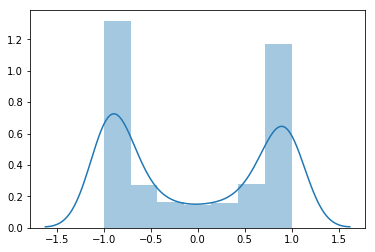

In [17]:
sns.distplot(A0.flatten())

In [18]:
class BipolarL1Regularizer(Regularizer):
    """Regularizer for L1-style bipolar regularization.
    # Arguments
        gamma: Float; bipolar regularization factor.
        alpha: Float; non-zero regularization factor.
        beta: Float; non-zero regularization decay.
    """

    def __init__(self, gamma=0.0, alpha=0.0, beta=0.0):
        self.gamma = K.cast_to_floatx(gamma)
        self.alpha = K.cast_to_floatx(alpha)
        self.beta = K.cast_to_floatx(beta)

    def __call__(self, x):
        regularization = 0.0
        if self.gamma:
            regularization += K.sum(self.gamma * K.abs(1-x) * K.abs(-1-x))
        if self.alpha and self.beta:
            regularization += K.sum(self.alpha * K.exp(-self.beta * K.abs(x)))
        return regularization

    def get_config(self):
        return {'gamma': float(self.gamma),
                'alpha': float(self.alpha),
                'beta': float(self.beta)}

In [19]:
def one_hidden_layer_learner_reg(X, Y, Nh, nonlinearity, loss, optimizer, fit_kwargs,
                                 gamma=0, alpha=0, beta=0):
    _, Ni = X.shape
    _, No = Y.shape

    # input tensor
    inp = Input(shape=(Ni,))
    h = Dense(Nh, activation=nonlinearity, name='hidden',
              activity_regularizer=BipolarL1Regularizer(gamma, alpha, beta))(inp)
    out = Dense(No, activation=nonlinearity)(h)

    model = Model(inputs=inp, outputs=out)

    model.compile(optimizer=optimizer, loss=loss)
    model.fit(X, Y, verbose=0, **fit_kwargs)

    return model

In [20]:
model_bin = one_hidden_layer_learner_reg(X_trg, Y_trg_0, 20, 'tanh', 'mse', 'RMSprop', 
                                     {'epochs': 2000, 'batch_size': 16},
                                     gamma=0.0001)
#                                      gamma=0.0001, alpha=0.0001, beta=0.0001)
learn_ann.errors(model_bin, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.11145833333333334,
 'test_errs': array([ 0.11145833]),
 'test_mcc': 0.69009135343571182,
 'test_mccs': array([ 0.69009135]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [21]:
A0_bin = learners.get_activations(model_bin, X_trg, 1)

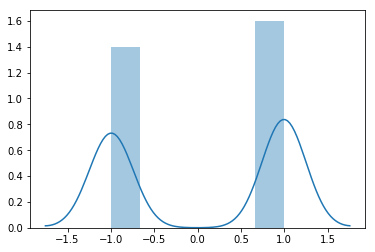

In [22]:
sns.distplot(A0_bin.flatten())

In [23]:
def bipolar_activation(x):
    cond = K.less(x, K.zeros_like(x))
    out = K.switch(cond, -K.ones_like(x), K.ones_like(x))
    return out

In [86]:
def thresholded_copy(trained_model):

    assert len(trained_model.layers) == 3
    
    # input tensor
    inp = trained_model.input
    trained_h = trained_model.layers[1]
    Lh = Dense(trained_h.units, activation=K.sign, trainable=False,
               weights=trained_h.get_weights())
    h = Lh(inp)
    
    trained_out = trained_model.layers[2]
    Lout = Dense(trained_out.units, activation=K.sign,
                 weights=trained_out.get_weights())
    out = Lout(h)
    
    model = Model(inputs=inp, outputs=out)

#     model.compile(optimizer=trained_model.optimizer, loss=trained_model.loss)
#     model.fit(X, Y, verbose=0, **fit_kwargs)

    return model

In [87]:
model_hard = thresholded_copy(model_bin)

In [105]:
np.unique(model_hard.predict(X_trg))

array([-1.,  1.], dtype=float32)

In [68]:
A0_bin_hard = learners.get_activations(model_hard, X_trg)

In [69]:
A0_bin_hard

[array([[ 1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.],
        [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
        [-1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.],
        [ 1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.],
        [-1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.],
        [-1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.],
        [-1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.],
        [ 1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.],
        [-1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.],
        [-1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.],
        [-1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.],
        [-1.,  1., -1., -1., -1.,  1., -

In [52]:
learners.get_activations(model_bin, X_trg)

[array([[ 1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.],
        [-1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
        [-1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.],
        [ 1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.],
        [-1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,  1.],
        [-1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.],
        [-1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.],
        [ 1.,  1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.],
        [-1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.],
        [-1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.],
        [-1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1.],
        [ 1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.],
        [-1.,  1., -1., -1., -1.,  1., -

In [70]:
learners.get_activations(model_hard, X_trg, 1)

array([[-1.,  1.,  1., ...,  1., -1., -1.],
       [ 1., -1., -1., ...,  1., -1., -1.],
       [-1., -1., -1., ...,  1.,  1., -1.],
       ..., 
       [ 1., -1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ..., -1., -1.,  1.]], dtype=float32)

In [71]:
learners.get_activations(model_bin, X_trg, 1)

array([[-0.99943721,  1.        ,  0.99999994, ...,  0.98822486,
        -0.99384546, -0.98448002],
       [ 0.99990475, -1.        , -1.        , ...,  0.9959324 ,
        -0.98724461, -0.9396199 ],
       [-0.99829018, -1.        , -0.99998611, ...,  0.99999815,
         0.99999964, -0.99999416],
       ..., 
       [ 0.9987697 , -0.99105674,  0.99999869, ...,  0.99782532,
         0.99495721,  0.99646699],
       [ 0.9999842 , -0.99053973,  0.99536258, ...,  0.99999899,
         0.97892302,  1.        ],
       [ 0.99999958,  1.        ,  1.        , ..., -0.99999642,
        -0.99986941,  0.99999672]], dtype=float32)

In [73]:
learn_ann.errors(model_bin, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.11145833333333334,
 'test_errs': array([ 0.11145833]),
 'test_mcc': 0.69009135343571182,
 'test_mccs': array([ 0.69009135]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [72]:
learn_ann.errors(model_hard, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.13645833333333332,
 'test_errs': array([ 0.13645833]),
 'test_mcc': 0.63179423380428712,
 'test_mccs': array([ 0.63179423]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [74]:
model_hard.fit(X_trg, Y_trg_0, verbose=0, **{'epochs': 2000, 'batch_size': 16})
learn_ann.errors(model_hard, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.13645833333333332,
 'test_errs': array([ 0.13645833]),
 'test_mcc': 0.63179423380428712,
 'test_mccs': array([ 0.63179423]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [77]:
model_bin.predict(X_tst)

array([[ 1.        ],
       [-0.83622783],
       [ 0.98142833],
       [-0.99999028],
       [-0.99990338],
       [-0.99996525],
       [-0.9987902 ],
       [-0.9999963 ],
       [ 0.99987501],
       [-0.06860477],
       [ 0.68612331],
       [ 0.99859065],
       [ 0.87813473],
       [ 0.99963707],
       [ 0.988594  ],
       [ 0.96275306],
       [ 0.9373216 ],
       [ 0.96515507],
       [ 0.96809828],
       [-0.98732144],
       [-0.99972361],
       [-0.99999547],
       [-0.99994427],
       [ 1.        ],
       [-0.98596072],
       [ 1.        ],
       [-0.48626614],
       [-0.94148475],
       [ 0.81231183],
       [ 0.9999724 ],
       [-0.97453058],
       [-0.99995297],
       [ 0.9999966 ],
       [-0.99999905],
       [ 0.71304798],
       [ 0.99999726],
       [-0.3154279 ],
       [-0.99877304],
       [-0.9999975 ],
       [ 0.99730265],
       [-0.99684644],
       [-0.74783617],
       [-0.99233449],
       [-0.99719596],
       [-0.63081843],
       [ 1

In [78]:
model_hard_2 = thresholded_copy(model)

In [79]:
learn_ann.errors(model, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.046875,
 'test_errs': array([ 0.046875]),
 'test_mcc': 0.8512060736667757,
 'test_mccs': array([ 0.85120607]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [80]:
learn_ann.errors(model_hard_2, X_trg, Y_trg_0, X_tst, Y_tst_0)

{'test_err': 0.074999999999999997,
 'test_errs': array([ 0.075]),
 'test_mcc': 0.77329420967486839,
 'test_mccs': array([ 0.77329421]),
 'trg_err': 0.0,
 'trg_errs': array([ 0.]),
 'trg_mcc': 1.0,
 'trg_mccs': array([ 1.])}

In [83]:
learners.get_activations(model_hard_2, X_tst)

[array([[ 1.,  1., -1., ...,  1.,  1., -1.],
        [-1., -1.,  1., ...,  1., -1., -1.],
        [ 1.,  1., -1., ..., -1., -1.,  1.],
        ..., 
        [-1.,  1., -1., ..., -1.,  1., -1.],
        [-1., -1.,  1., ...,  1., -1.,  1.],
        [-1., -1., -1., ...,  1., -1.,  1.]], dtype=float32),
 array([[ 1.,  1., -1., ..., -1., -1., -1.],
        [-1.,  1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ...,  1.,  1.,  1.],
        ..., 
        [ 1., -1.,  1., ...,  1.,  1., -1.],
        [-1.,  1.,  1., ..., -1., -1., -1.],
        [-1.,  1.,  1., ..., -1., -1.,  1.]], dtype=float32),
 array([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        